In [43]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [44]:
# Data Preparation

# Parameters
tickers = ['AAPL', 'NVDA', 'GOOGL', 'MSFT']
start = '2020-01-01'

# YF download
df = yf.download(tickers, start=start)

# Reformat Dataframe
df = df.stack().reset_index()

# Add daily return column
df['Return'] = df.groupby("Ticker")['Adj Close'].pct_change()

df = df.dropna()

df

[*********************100%%**********************]  4 of 4 completed
C:\Users\andre\AppData\Local\Temp\ipykernel_22592\574905005.py:11: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack().reset_index()


Price,Date,Ticker,Adj Close,Close,High,Low,Open,Volume,Return
4,2020-01-03,AAPL,72.251129,74.357498,75.144997,74.125000,74.287498,146322800,-0.009722
5,2020-01-03,GOOGL,67.997955,68.075996,68.687500,67.365997,67.400002,23408000,-0.005231
6,2020-01-03,MSFT,152.295395,158.619995,159.949997,158.059998,158.320007,21116200,-0.012452
7,2020-01-03,NVDA,5.878019,5.901750,5.945750,5.852500,5.877500,205384000,-0.016006
8,2020-01-06,AAPL,72.826859,74.949997,74.989998,73.187500,73.447502,118387200,0.007968
...,...,...,...,...,...,...,...,...,...
4635,2024-08-09,NVDA,104.750000,104.750000,106.599998,103.430000,105.639999,290844200,-0.002096
4636,2024-08-12,AAPL,217.529999,217.529999,219.509995,215.600006,216.070007,37992400,0.005966
4637,2024-08-12,GOOGL,162.289993,162.289993,164.899994,161.839996,164.350006,15882400,-0.008432
4638,2024-08-12,MSFT,406.809998,406.809998,408.760010,404.239990,407.059998,16739400,0.001946


In [45]:
port = df.groupby('Ticker')['Return'].mean().rename("Expected Return").to_frame().reset_index()

port['Volatility'] = df.groupby('Ticker')['Return'].std().to_list()

port

,Ticker,Expected Return,Volatility
0,AAPL,0.001153,0.020513
1,GOOGL,0.000961,0.020735
2,MSFT,0.001031,0.019675
3,NVDA,0.003094,0.034399


In [46]:
# Return Matrix
return_matrix = df[['Date','Ticker','Return']].pivot(index='Date', columns='Ticker', values='Return').dropna()

return_matrix

Ticker,AAPL,GOOGL,MSFT,NVDA
Date,,,,
2020-01-03,-0.009722,-0.005231,-0.012452,-0.016006
2020-01-06,0.007968,0.026654,0.002585,0.004194
2020-01-07,-0.004703,-0.001932,-0.009118,0.012107
2020-01-08,0.016086,0.007118,0.015928,0.001876
2020-01-09,0.021241,0.010498,0.012493,0.010982
...,...,...,...,...
2024-08-06,-0.009748,-0.006028,0.011287,0.037830
2024-08-07,0.012498,0.004106,-0.002953,-0.051223
2024-08-08,0.016633,0.019441,0.010692,0.061268


In [47]:
# Covariance Matrix
cov_matrix = return_matrix.cov().values

cov_matrix

array([[0.00042076, 0.00028219, 0.00030466, 0.00043618],
       [0.00028219, 0.00042993, 0.00030981, 0.00043393],
       [0.00030466, 0.00030981, 0.00038712, 0.00046772],
       [0.00043618, 0.00043393, 0.00046772, 0.00118326]])

In [48]:
# Expected Returns Vector
expected_returns = port['Expected Return'].values

expected_returns

array([0.00115296, 0.00096136, 0.00103079, 0.0030944 ])

In [49]:
# Portfolio functions

def portfolio_return(weights, expected_returns):
    return np.sum(weights * expected_returns)

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(np.matmul(weights,cov_matrix),weights.T))

def negative_sharpe_ratio(weights, expected_returns, cov_matrix):
    port_er = portfolio_return(weights, expected_returns)
    port_std = portfolio_volatility(weights, cov_matrix)
    return -port_er / port_std

In [50]:
# Display Weights Function

def display_weights(tickers, weights):
    df = pd.DataFrame()
    df['Ticker'] = tickers
    df['Weight'] = [round(weight, 2) for weight in weights]

    display(df)

In [51]:
# Initial Weights
size = len(tickers)
initial_weights = np.array([1/size] * size)

initial_weights

array([0.25, 0.25, 0.25, 0.25])

In [52]:
# Baseline results

# Baseline Results
port_return = portfolio_return(initial_weights, expected_returns)
port_volatiliy = portfolio_volatility(initial_weights,cov_matrix)
port_sharpe = port_return / port_volatiliy

# Formatting
port_return = round(port_return * 100, 2)
port_volatiliy = round(port_volatiliy * 100, 2)
port_sharpe = round(port_sharpe, 2)

display_weights(tickers, initial_weights)
print(f"Portfolio Return: {port_return} %")
print(f"Portfolio Volatility: {port_volatiliy} %")
print(f"Portfolio Sharpe Ratio: {port_sharpe}")

,Ticker,Weight
0,AAPL,0.25
1,NVDA,0.25
2,GOOGL,0.25
3,MSFT,0.25


Portfolio Return: 0.16 %
Portfolio Volatility: 2.08 %
Portfolio Sharpe Ratio: 0.08


In [53]:
# Optimization

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # weights sum to 1
bounds = tuple((0, 1) for _ in range(len(tickers)))  # each weight between 0 and 1

result = minimize(negative_sharpe_ratio, initial_weights, 
                  args=(expected_returns, cov_matrix),
                  method='SLSQP', bounds=bounds, constraints=constraints)

optimal_weights = result.x

optimal_weights

array([2.23614087e-02, 1.04083409e-17, 8.67361738e-18, 9.77638591e-01])

In [54]:
# Optimal Results
opt_port_return = portfolio_return(optimal_weights, expected_returns)
opt_port_volatility = portfolio_volatility(optimal_weights,cov_matrix)
opt_sharpe_ratio = opt_port_return / opt_port_volatility

# Formatting
opt_port_return = round(opt_port_return * 100, 2)
opt_port_volatility = round(opt_port_volatility * 100, 2)
opt_sharpe_ratio = round(opt_sharpe_ratio, 2)

display_weights(tickers,optimal_weights)
print(f"Optimized Portfolio Return: {opt_port_return} %")
print(f"Optimized Portfolio Volatility: {opt_port_volatility} %")
print(f"Optimized Portfolio Sharpe Ratio: {opt_sharpe_ratio}")

,Ticker,Weight
0,AAPL,0.02
1,NVDA,0.00
2,GOOGL,0.00
3,MSFT,0.98


Optimized Portfolio Return: 0.31 %
Optimized Portfolio Volatility: 3.39 %
Optimized Portfolio Sharpe Ratio: 0.09


In [55]:
# Efficient Frontier Chart

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(len(tickers)))

def mve_portfolio(target_return, expected_returns, cov_matrix):
    n = len(tickers)
    args = (expected_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x, expected_returns) - target_return},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    result = minimize(portfolio_volatility, n*[1./n,], args=args[1],
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

In [56]:
n_points = 100
target_returns = np.linspace(expected_returns.min(), expected_returns.max(), n_points)
mve_portfolios = [mve_portfolio(target, expected_returns, cov_matrix) for target in target_returns]

returns = [portfolio_return(w, expected_returns) for w in mve_portfolios]
volatilities = [portfolio_volatility(w, cov_matrix) for w in mve_portfolios]

returns = [metric * 100 for metric in returns]
volatilities = [metric * 100 for metric in volatilities]

portfolios = pd.DataFrame()
portfolios['Name'] = [f"Portfolio {x+1}" for x in range(len(mve_portfolios))]
portfolios['Expected Return'] = returns
portfolios['Volatility'] = volatilities

portfolios

,Name,Expected Return,Volatility
0,Portfolio 1,0.096136,2.073472
1,Portfolio 2,0.098291,1.934921
2,Portfolio 3,0.100445,1.879106
3,Portfolio 4,0.102600,1.847890
4,Portfolio 5,0.104755,1.836299
...,...,...,...
95,Portfolio 96,0.300822,3.344215
96,Portfolio 97,0.302977,3.367980
97,Portfolio 98,0.305131,3.391844
98,Portfolio 99,0.307286,3.415805


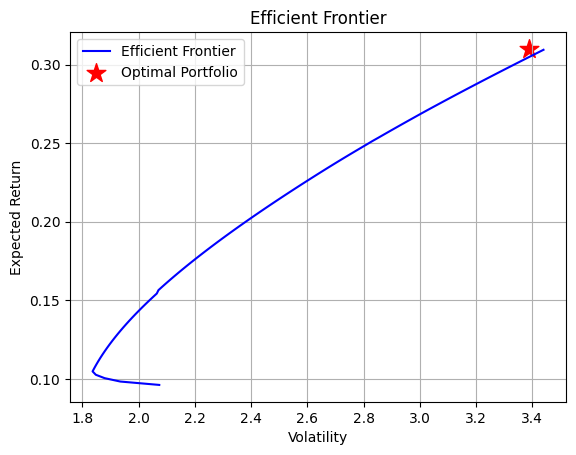

In [57]:
plt.plot(volatilities, returns, 'b-', label='Efficient Frontier')
plt.scatter(opt_port_volatility, opt_port_return, color='r', marker='*', s=200, label='Optimal Portfolio')

# Plot individual assets
# for i, ticker in enumerate(tickers):
# plt.scatter(port['Volatility'], port['Expected Return'], hue=port['Ticker'])

plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.legend()
plt.grid(True)
plt.show()